#### Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

In [2]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm 

## Data Extraction

For this strategy we extract all the equities listed in the **NIFTY METAL** index. Idea is to identify CoIntegrated pairs of stocks and capitalize on the realtive movement of the two assets.

In [3]:
# NIFTY METAL stocks
tickers = ['ADANIENT.BO',
           'APLAPOLLO.BO',
           'COALINDIA.BO',
           'HINDALCO.BO',
           'HINDZINC.BO',
           'JINDALSTEL.BO',
           'JSWSTEEL.BO',
           'MOIL.BO',
           'NATIONALUM.BO',
           'NMDC.BO',
           'RATNAMANI.BO',
           'SAIL.BO',
           'TATASTEEL.BO',
           'VEDL.BO',
           'WELCORP.BO',]
start_date = '2023-01-01'
end_date = '2024-11-01'

# Downloading per-day from Yahoo! Finance
data = yf.download(tickers, start=start_date, end=end_date, interval='1d', group_by='ticker')

[*********************100%***********************]  15 of 15 completed


In [4]:
# Check for any missing entries
data[data.isnull().any(axis=1)]

Empty DataFrame
Columns: [(ADANIENT.BO, Open), (ADANIENT.BO, High), (ADANIENT.BO, Low), (ADANIENT.BO, Close), (ADANIENT.BO, Adj Close), (ADANIENT.BO, Volume), (JSWSTEEL.BO, Open), (JSWSTEEL.BO, High), (JSWSTEEL.BO, Low), (JSWSTEEL.BO, Close), (JSWSTEEL.BO, Adj Close), (JSWSTEEL.BO, Volume), (SAIL.BO, Open), (SAIL.BO, High), (SAIL.BO, Low), (SAIL.BO, Close), (SAIL.BO, Adj Close), (SAIL.BO, Volume), (VEDL.BO, Open), (VEDL.BO, High), (VEDL.BO, Low), (VEDL.BO, Close), (VEDL.BO, Adj Close), (VEDL.BO, Volume), (APLAPOLLO.BO, Open), (APLAPOLLO.BO, High), (APLAPOLLO.BO, Low), (APLAPOLLO.BO, Close), (APLAPOLLO.BO, Adj Close), (APLAPOLLO.BO, Volume), (RATNAMANI.BO, Open), (RATNAMANI.BO, High), (RATNAMANI.BO, Low), (RATNAMANI.BO, Close), (RATNAMANI.BO, Adj Close), (RATNAMANI.BO, Volume), (HINDZINC.BO, Open), (HINDZINC.BO, High), (HINDZINC.BO, Low), (HINDZINC.BO, Close), (HINDZINC.BO, Adj Close), (HINDZINC.BO, Volume), (COALINDIA.BO, Open), (COALINDIA.BO, High), (COALINDIA.BO, Low), (COALINDIA.BO, Close), (COALINDIA.BO, Adj Close), (COALINDIA.BO, Volume), (TATASTEEL.BO, Open), (TATASTEEL.BO, High), (TATASTEEL.BO, Low), (TATASTEEL.BO, Close), (TATASTEEL.BO, Adj Close), (TATASTEEL.BO, Volume), (NATIONALUM.BO, Open), (NATIONALUM.BO, High), (NATIONALUM.BO, Low), (NATIONALUM.BO, Close), (NATIONALUM.BO, Adj Close), (NATIONALUM.BO, Volume), (WELCORP.BO, Open), (WELCORP.BO, High), (WELCORP.BO, Low), (WELCORP.BO, Close), (WELCORP.BO, Adj Close), (WELCORP.BO, Volume), (NMDC.BO, Open), (NMDC.BO, High), (NMDC.BO, Low), (NMDC.BO, Close), (NMDC.BO, Adj Close), (NMDC.BO, Volume), (JINDALSTEL.BO, Open), (JINDALSTEL.BO, High), (JINDALSTEL.BO, Low), (JINDALSTEL.BO, Close), (JINDALSTEL.BO, Adj Close), (JINDALSTEL.BO, Volume), (MOIL.BO, Open), (MOIL.BO, High), (MOIL.BO, Low), (MOIL.BO, Close), (MOIL.BO, Adj Close), (MOIL.BO, Volume), (HINDALCO.BO, Open), (HINDALCO.BO, High), (HINDALCO.BO, Low), (HINDALCO.BO, Close), (HINDALCO.BO, Adj Close), (HINDALCO.BO, Volume)]
Index: []

[0 rows x 90 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 2023-01-02 00:00:00+00:00 to 2024-10-31 00:00:00+00:00
Data columns (total 90 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (ADANIENT.BO, Open)         433 non-null    float64
 1   (ADANIENT.BO, High)         433 non-null    float64
 2   (ADANIENT.BO, Low)          433 non-null    float64
 3   (ADANIENT.BO, Close)        433 non-null    float64
 4   (ADANIENT.BO, Adj Close)    433 non-null    float64
 5   (ADANIENT.BO, Volume)       433 non-null    int64  
 6   (JSWSTEEL.BO, Open)         433 non-null    float64
 7   (JSWSTEEL.BO, High)         433 non-null    float64
 8   (JSWSTEEL.BO, Low)          433 non-null    float64
 9   (JSWSTEEL.BO, Close)        433 non-null    float64
 10  (JSWSTEEL.BO, Adj Close)    433 non-null    float64
 11  (JSWSTEEL.BO, Volume)       433 non-null    int64  
 12  (SAIL.BO, Open)             433 non-null   

In [6]:
data.dropna(inplace=True)

In [7]:
# data.to_parquet('stocks_data.parquet')

In [8]:
# Saving the downloaded data, for easy access
stock_df = pd.read_parquet('stocks_data.parquet') # file type '.parquet' helps preserve the structure of the dataset

## Data Visualization

Log Returns Calculation, to help stabilize volatility and make statistical relationships easier to identify

In [9]:
log_returns = {}
closing_prices = {}

for ticker in tickers:
    log_returns[ticker] = np.log(stock_df[ticker]['Close'] / stock_df[ticker]['Close'].shift(1)).dropna()
    closing_prices[ticker] = stock_df[ticker]['Close']

log_returns_df = pd.DataFrame(log_returns)
closing_prices_df = pd.DataFrame(closing_prices)

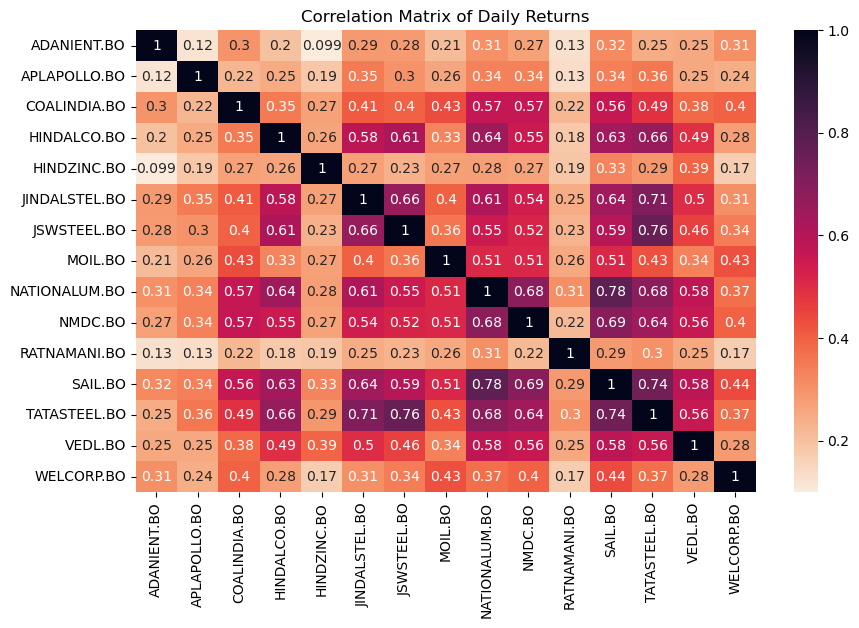

In [10]:
# Calculating Correlation Matrix
corr_matrix = log_returns_df.corr()

# Plotting Correlation Matrix to visulize the correlated stocks
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='rocket_r')
plt.title('Correlation Matrix of Daily Returns')
plt.show()

## Identify Co-integrated Pairs

In [11]:
# Function to test if two series are Cointegrated (using Augment Dickey-Fuller test for stationarity)
def test_cointegration(series1, series2):
    model = sm.OLS(series1, sm.add_constant(series2)).fit()
    spread = model.resid
    adf_result = adfuller(spread)
    p_value = adf_result[1]
    return p_value < 0.1

In [12]:
# Function to find pairs with correlation above the threshold
def find_cointegrated_pairs(log_returns_df, correlation_threshold):
    corr_matrix = log_returns_df.corr()
    cointegrated_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            ticker1 = corr_matrix.columns[i]
            ticker2 = corr_matrix.columns[j]
            correlation = corr_matrix.iloc[i, j]
            
            # Check if correlation is above the threshold
            if abs(correlation) >= correlation_threshold:
                # Test for cointegration
                if test_cointegration(log_returns_df[ticker1].dropna(), log_returns_df[ticker2].dropna()):
                    cointegrated_pairs.append((ticker1, ticker2, correlation))
    
    return cointegrated_pairs

In [13]:
# Experiment with different thresholds
thresholds = [0.7, 0.75, 0.8]
pairs_results = {}

for threshold in thresholds:
    pairs = find_cointegrated_pairs(log_returns_df, correlation_threshold=threshold)
    pairs_results[threshold] = pairs

In [14]:
# Display the results for each threshold
for threshold, pairs in pairs_results.items():
    print(f"Threshold: {threshold}")
    print(f"    Cointegrated pairs found: {len(pairs)}")
    for pair in pairs:
        print(f"        Pair: {pair[0]} and {pair[1]} with correlation {pair[2]:.2f}")
    print('--------------------------------------------')

Threshold: 0.7
    Cointegrated pairs found: 4
        Pair: JINDALSTEL.BO and TATASTEEL.BO with correlation 0.71
        Pair: JSWSTEEL.BO and TATASTEEL.BO with correlation 0.76
        Pair: NATIONALUM.BO and SAIL.BO with correlation 0.78
        Pair: SAIL.BO and TATASTEEL.BO with correlation 0.74
--------------------------------------------
Threshold: 0.75
    Cointegrated pairs found: 2
        Pair: JSWSTEEL.BO and TATASTEEL.BO with correlation 0.76
        Pair: NATIONALUM.BO and SAIL.BO with correlation 0.78
--------------------------------------------
Threshold: 0.8
    Cointegrated pairs found: 0
--------------------------------------------


In [15]:
# Assume 'results' contains the found pairs from the previous step
selected_threshold = 0.75
selected_pairs = pairs_results[selected_threshold]

# Display the identified pairs
print(f"Cointegrated pairs found at threshold {selected_threshold}:")
for i, pair in enumerate(selected_pairs):
    print(f"    Pair {i+1}: {pair[0]} and {pair[1]} with correlation {pair[2]:.2f}")

Cointegrated pairs found at threshold 0.75:
    Pair 1: JSWSTEEL.BO and TATASTEEL.BO with correlation 0.76
    Pair 2: NATIONALUM.BO and SAIL.BO with correlation 0.78


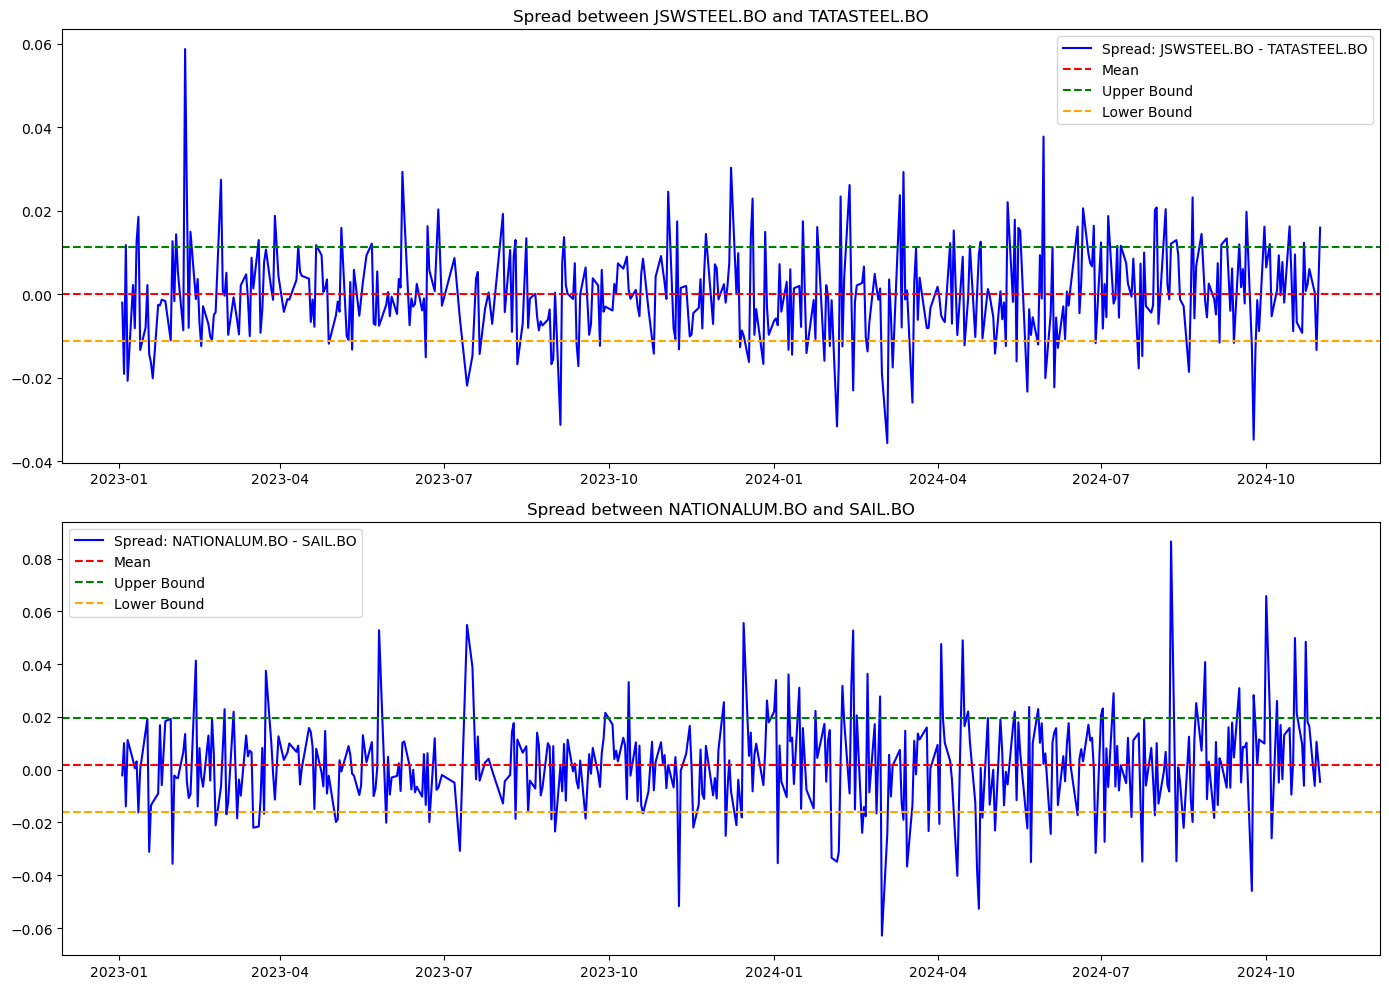

In [16]:
# Visualize the spreads of each identified pair
plt.figure(figsize=(14, 10))

for i, (ticker1, ticker2, _) in enumerate(selected_pairs):
    plt.subplot(len(selected_pairs), 1, i + 1)
    spread = log_returns_df[ticker1] - log_returns_df[ticker2]
    plt.plot(spread.index, spread, label=f'Spread: {ticker1} - {ticker2}', color='blue')
    plt.axhline(spread.mean(), linestyle='--', color='red', label='Mean')
    plt.axhline(spread.mean() + spread.std(), linestyle='--', color='green', label='Upper Bound')
    plt.axhline(spread.mean() - spread.std(), linestyle='--', color='orange', label='Lower Bound')
    plt.title(f'Spread between {ticker1} and {ticker2}')
    plt.legend()

plt.tight_layout()
plt.show()

## Main Loop

### Hedging Mechanism in Pairs Trading
Pairs trading is an inherently market-neutral strategy designed to capitalize on the relative movement between two correlated assets rather than relying on their individual price directions. By constructing a balanced long-short portfolio, this strategy helps mitigate exposure to broader market trends and reduces systematic risk.

- In pairs trading, we take a long position in one asset while simultaneously taking a short position in a correlated counterpart. This simultaneous long-short structure provides market neutrality. When the overall market rises or falls, both assets are likely to experience similar directional pressures due to their correlation. The gains in one position can offset the losses in the other, creating a built-in hedge against broad market volatility. As a result, the strategy relies on the convergence or divergence of the asset pair’s relative values rather than directional market moves.

- If both assets belong to the same sector (like the metal sector chosen here), the strategy also provides hedging against sector-specific risks like regulatory changes or interest rate fluctuations. Any impact on the sector affects both assets similarly, allowing the strategy to profit from relative mispricing rather than sector performance.

- In times of high volatility, such as economic recessions or market corrections, directional strategies often face high risk. Pairs trading, however, can perform well in these conditions as the relative-value approach remains largely unaffected by market-wide price swings. By focusing on the mean-reverting behavior of the asset pair, pairs trading offers a layer of protection in volatile markets, where price movements are more driven by macro factors.

In [17]:
# Dividing the dataset into train and test
split_date = '2024-01-01'
training_period = log_returns_df.index[log_returns_df.index < pd.to_datetime(split_date, utc=True)]
testing_period = log_returns_df.index[~ (log_returns_df.index < pd.to_datetime(split_date, utc=True))]

In [18]:
# Calculating the mean and standard deviation for the pairs from the training period
pair_stats = {}
training_log_returns = log_returns_df.loc[training_period]
for ticker1, ticker2, _ in selected_pairs:
    spread = training_log_returns[ticker1] - training_log_returns[ticker2]
    pair_stats[(ticker1,ticker2)] = (spread.mean(), spread.std())

In [ ]:
# parameters
entry_threshold = 1
portfolio_value = 10000

# initialization
last_trade_positions = {}
last_trade_prices = {}
for ticker1, ticker2, _ in selected_pairs:
    last_trade_prices[(ticker1, ticker2)] = np.array([0,0])
    last_trade_positions[(ticker1, ticker2)] = np.array([0,0])

# Main Loop
results = []
for date in testing_period:
    # print(f'For the given day: {date.date()}')
    day_prices = closing_prices_df.loc[date]
    day_log_returns = log_returns_df.loc[date]

    day_return = 0
    for ticker1, ticker2, _ in selected_pairs:
        # print(f'    For pair: {ticker1, ticker2}')
        pair_mean, pair_std = pair_stats[(ticker1, ticker2)]
        spread = day_log_returns[ticker1] - day_log_returns[ticker2]

        last_pair_position = last_trade_positions[(ticker1, ticker2)]
        last_pair_prices = last_trade_prices[(ticker1, ticker2)]

        current_pair_prices = np.array([day_prices[ticker1], day_prices[ticker2]])
        
        # Trading logic
        if spread > pair_mean + entry_threshold * pair_std:
            current_pair_position = np.array([-1,1])    # short-long
        elif spread < pair_mean - entry_threshold * pair_std:
            current_pair_position = np.array([1,-1])    # long-short
        else:
            current_pair_position = np.array([0,0])     # exit legs of trade
        
        # No trade if still the same position persists
        if (current_pair_position == last_pair_position).all():
            # print('     No trade done')
            # print('     ------------------')
            continue
        
        # Update the positions and prices of the pairs
        last_trade_positions[(ticker1, ticker2)] = current_pair_position
        last_trade_prices[(ticker1, ticker2)] = current_pair_prices

        if (current_pair_position == np.array([0,0])).all():
            # print('     Exiting all legs of trade')
            current_return = last_pair_position * (current_pair_prices - last_pair_prices)
            day_return += current_return.sum()

        elif (last_pair_position == np.array([0,0])).all():
            # print('     Executing a trade')
            current_return = np.array([0,0])

        else:
            # print('     Switching to contrast trade and calculating return')
            current_return = last_pair_position * (current_pair_prices - last_pair_prices)
            day_return += current_return.sum()

        # print('     ------------------')
    # Assuming we traded 10 units of stocks each time
    total_return = day_return * 10
    
    portfolio_value += total_return
    
    results.append((date.date(),
                    total_return,
                    portfolio_value
                    ))
    # print('________________________')

results_df = pd.DataFrame(results, columns=['Date',
                                            'PnL', 'Portfolio Value']).set_index('Date')

In [ ]:
results_df['Daily Return'] = results_df['Portfolio Value'].pct_change().fillna(0)

## Visualization and Final Comments

In [21]:
# Extracting the OHLCV data for NIFTY50 for the year 2024 till Nov'24
nifty_data = yf.download('^NSEI', start=split_date, end='2024-11-01', interval='1d')
nifty_returns = nifty_data['Close'].pct_change().fillna(0)

[*********************100%***********************]  1 of 1 completed


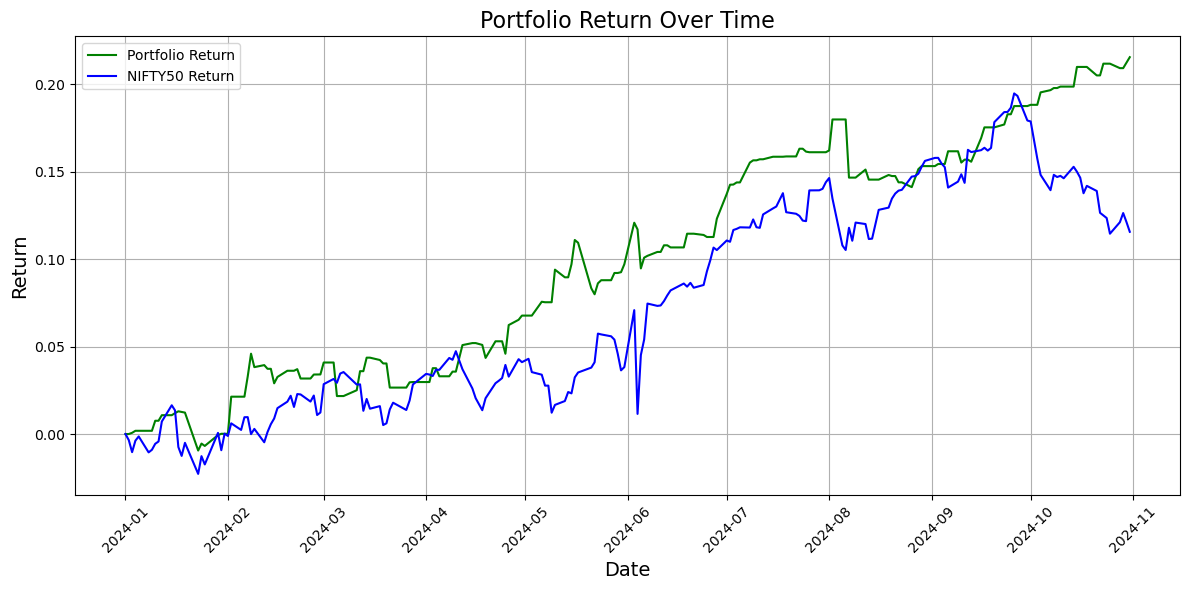

In [22]:
# Plottting daily returns for Portfolio and NIFTY50
plt.figure(figsize=(12,6))
# plt.plot(results_df.index, results_df['Portfolio Value'].pct_change().fillna(0).cumsum(), linestyle='-', color='g', label='Portfolio Return')
plt.plot(results_df.index, results_df['Daily Return'].cumsum(), linestyle='-', color='g', label='Portfolio Return')
plt.plot(nifty_returns.index, nifty_returns.cumsum(), linestyle='-', color='b', label='NIFTY50 Return')
plt.title('Portfolio Return Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Return', fontsize=14)
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The pairs trading strategy demonstrates impressive resilience and outperformance during the current bear market, i.e. During the month Oct'24.

Despite overall market declines, the strategy capitalizes on price divergences between correlated assets, showing that relative-value trading can still generate positive returns when directional strategies are facing losses.